In [1]:
# Librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Análisis exploratorio

In [66]:
x_column_names = ["age",
             "sex",
             "cp",
             "trestbps",
             "chol",
             "fbs",
             "restecg",
             "thalach",
             "exang",
             "oldpeak",
             "slope",
             "ca",
             "thal"]
y_column_name = ["num"]
df_x = pd.read_csv("../Data/processed.cleveland.csv")[x_column_names]
df_y = pd.read_csv("../Data/processed.cleveland.csv")[y_column_name]
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(13)
memory usage: 30.9 KB


Nos damos cuenta de que ca y thal tienen valores faltantes por lo que vamos a aplicar técnicas de sustitución de estos valores. Se podría considerar despreciable el porcentaje de ellos, pero al tratarse de sustituciones rápidas, se decide proceder con estas técnicas.
Como son categoricas, la sustitución se realiza por la moda. 

In [67]:
# Modas CA y Thal
df_x[["ca","thal"]].mode(axis=0, numeric_only=False, dropna=True)

,ca,thal
0,0.0,3.0


In [68]:
# sustitución por moda. 
df_x.ca.fillna(0.0, inplace=True)
df_x.thal.fillna(3.0, inplace=True)
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
dtypes: float64(13)
memory usage: 30.9 KB


## Análisis de outliers

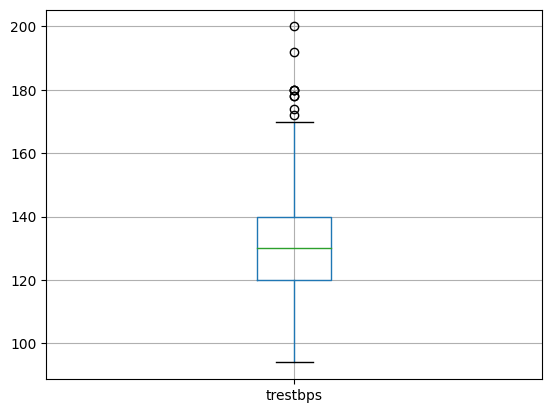

In [69]:
# Aunque los valores de 190 y 200 son atipicos, es probable que sean reales. No se eliminan. 
# Fuente: Médico interno de pregrado Fernanda Hernández Jiménez
df_x[["trestbps"]].boxplot()
plt.show()

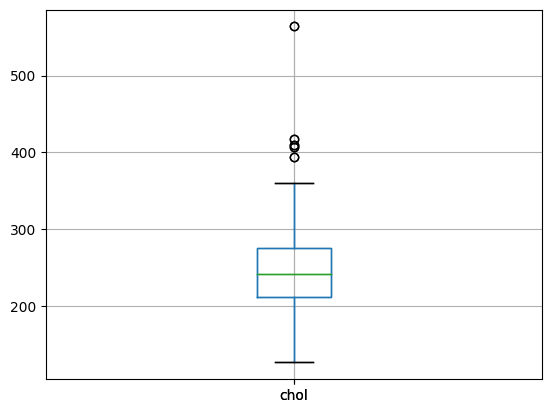

In [34]:
# Los outliers son posibles. Fuente: Médico interno de pregrado Fernanda Hernández Jiménez
df_x[["chol"]].boxplot()
plt.show()

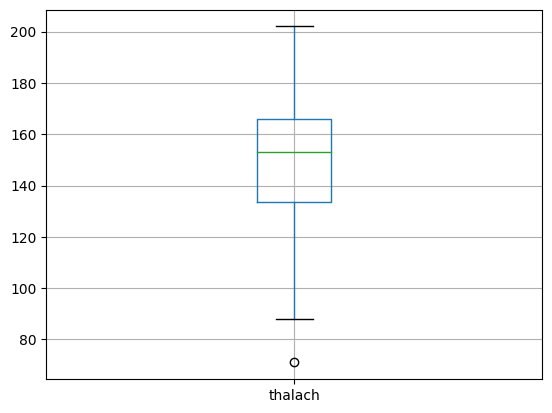

In [35]:
# Valores normales (Para frecuencia máxima alcanzada)
# Fuente: Médico interno de pregrado Fernanda Hernández Jiménez
df_x[["thalach"]].boxplot()
plt.show()

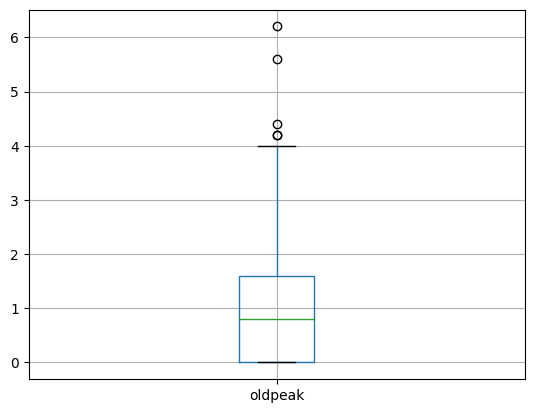

In [37]:
# Depresión en milimetros (en el eje de los minivoltios y) del ST, es posible.
# Fuente: Médico interno de pregrado Fernanda Hernández Jiménez
df_x[["oldpeak"]].boxplot()
plt.show()

## Distribución de las variables

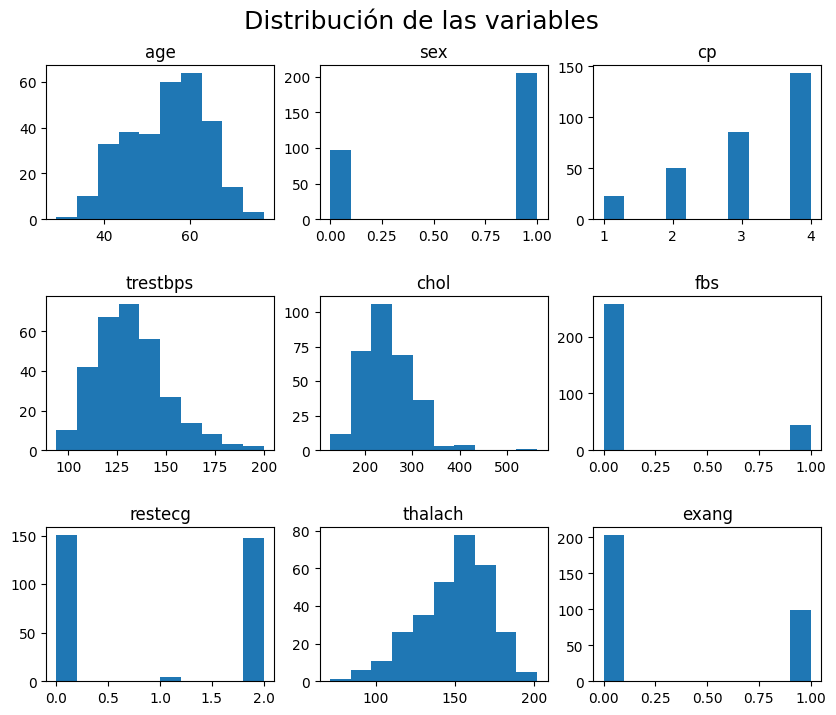

In [38]:
# Imprimir la distribución de las variables
# Se define el grid de la subplot
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Distribución de las variables", fontsize=18, y=0.95)

for col_name, ax in zip(df_x.columns, axs.ravel()):
    ax.hist(df_x[col_name].dropna(), bins=10)
    ax.set_title(col_name)
plt.show()

# División de conjuntos de entrenamiento y pruebas

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y.num,
                                                    test_size=0.3)

# Regresión logística sin tratamiento previo (reg_log)

In [81]:
# Usar regularización L1 (Lasso)
reg_log = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
reg_log.fit(X_train,Y_train)
# Salida Y & "hat" (ŷ) que denota predicciones estimadas.
Yhat1_train = reg_log.predict(X_train)
Yhat1_test = reg_log.predict(X_test)
print(f'Entrenamiento accuracy score: {accuracy_score(Y_train,Yhat1_train):0.2f}')
print(f'Prueba accuracy score: {accuracy_score(Y_test,Yhat1_test):0.2f}')

Entrenamiento accuracy score: 0.67
Prueba accuracy score: 0.54


# Regresión logística con reducción de variables por PCA (reg_log_rdv_PCA)

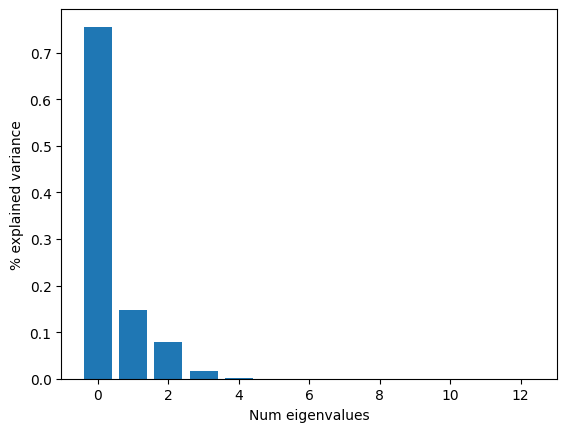

In [94]:
pca_model = PCA()
pca_model.fit(X_train)
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

# View the covariance ratio
plt.bar(np.arange(len(pca_model.explained_variance_ratio_)),pca_model.explained_variance_ratio_)
plt.xlabel('Num eigenvalues')
plt.ylabel('% explained variance')
plt.show()

In [95]:
# asignamos un threshold para seleccionar los componentes principales que contengan el 95% de la varianza
threshold = 0.95
idx = np.cumsum(pca_model.explained_variance_ratio_)<=threshold
X_train_pca = X_train_pca[:,idx]
X_test_pca = X_test_pca[:,idx]

In [98]:
# Regresión logística con reducción de variables por PCA (reg_log_rdv_PCA)
# Regresión con Lasso
reg_log_rdv_PCA = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
reg_log_rdv_PCA.fit(X_train_pca,Y_train)
# Salida Y & "hat" (ŷ) que denota predicciones estimadas.
Yhat_rdv_PCA_train = reg_log_rdv_PCA.predict(X_train_pca)
Yhat_rdv_PCA_test = reg_log_rdv_PCA.predict(X_test_pca)
print(f'Entrenamiento accuracy score: {accuracy_score(Y_train,Yhat_rdv_PCA_train):0.2f}')
print(f'Prueba accuracy score: {accuracy_score(Y_test,Yhat_rdv_PCA_test):0.2f}')

Entrenamiento accuracy score: 0.55
Prueba accuracy score: 0.49


# Regresión logística con reducción de variables por LDA (reg_log_rdv_LDA)

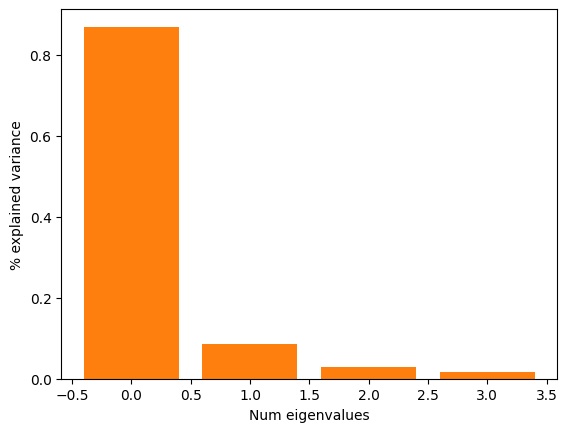

In [100]:
lda_model = LDA(store_covariance=True)
lda_model = lda_model.fit(X_train,Y_train)

# View the covariance ratio
plt.bar(np.arange(len(lda_model.explained_variance_ratio_)),lda_model.explained_variance_ratio_)
plt.xlabel('Num eigenvalues')
plt.ylabel('% explained variance')
plt.show()

In [111]:
# Transformación de datos con el modelo lda
X_train_lda = lda_model.transform(X_train)
X_test_lda = lda_model.transform(X_test)
threshold = 0.95
idx = np.cumsum(lda_model.explained_variance_ratio_)<=threshold
# reducción de variables
X_train_lda = X_train_lda[:,idx]
X_test_lda = X_test_lda[:,idx]
# Visualización
X_test_lda[0:10]

array([[-1.66154139],
       [-0.54380526],
       [-0.61885845],
       [-0.68644292],
       [ 1.50371256],
       [ 2.20017074],
       [ 4.31839281],
       [ 1.27210639],
       [ 2.87191461],
       [ 0.31510736]])

In [112]:

# Entrenando el modelo de regresión logistica
reg_log_rdv_LDA = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
reg_log_rdv_LDA.fit(X_train_lda,Y_train)
# Salida Y & "hat" (ŷ) que denota predicciones estimadas.
Yhat_rdv_LDA_train = reg_log_rdv_LDA.predict(X_train_lda)
Yhat_rdv_LDA_test = reg_log_rdv_LDA.predict(X_test_lda)
print(f'Entrenamiento accuracy score: {accuracy_score(Y_train,Yhat_rdv_LDA_train):0.2f}')
print(f'Prueba accuracy score: {accuracy_score(Y_test,Yhat_rdv_LDA_test):0.2f}')

Entrenamiento accuracy score: 0.65
Prueba accuracy score: 0.54


# Predicción del modelo LDA puro

In [113]:
Yhat_lda_train = lda_model.predict(X_train)
Yhat_lda_test = lda_model.predict(X_test)
print(f'Entrenamiento accuracy score: {accuracy_score(Y_train,Yhat_lda_train):0.2f}')
print(f'Prueba accuracy score: {accuracy_score(Y_test,Yhat_lda_test):0.2f}')

Entrenamiento accuracy score: 0.68
Prueba accuracy score: 0.49
